### Load Dataset and perform Exploratory Data Analysis:  

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_deposit():
    # Load csv dataset
    term_deposit_filepath = '../data/raw/term-deposit-marketing-2020.csv'
    #customer_survey_filepath = 'ACME-HappinessSurvey2020.csv'
    term_deposit = pd.read_csv(term_deposit_filepath)
    return term_deposit
term_deposit = load_deposit()

### Exploratory Data Analysis:  


In [7]:
term_deposit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
term_deposit.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [3]:
# Identify the categorical columns from the dataset.
categorical_cols = term_deposit.select_dtypes(include=['object']).columns
numerical_cols = term_deposit.select_dtypes(include=['int64']).columns

# Obtain unique values for each categorical column and count their occurrences for each column
category_summary = {col: term_deposit[col].value_counts().to_frame(name="count") for col in categorical_cols}
# Combine the summaries into a single dataframe for display
summary_combined = pd.concat(category_summary, axis=0)
summary_combined.index.names = ["feature", "category"]
print(summary_combined)

                         count
feature   category            
job       blue-collar     9383
          management      8166
          technician      6852
          admin           4483
          services        3910
          retired         1437
          self-employed   1414
          entrepreneur    1405
          unemployed      1104
          housemaid       1087
          student          524
          unknown          235
marital   married        24386
          single         10889
          divorced        4725
education secondary      20993
          tertiary       11206
          primary         6270
          unknown         1531
default   no             39191
          yes              809
housing   yes            24031
          no             15969
loan      no             33070
          yes             6930
contact   cellular       24914
          unknown        12765
          telephone       2321
month     may            13532
          jul             6380
        

#### Explore unknown values in dataset  

In [10]:
unknown_counts = (term_deposit == 'unknown').sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts

job            235
education     1531
contact      12765
dtype: int64

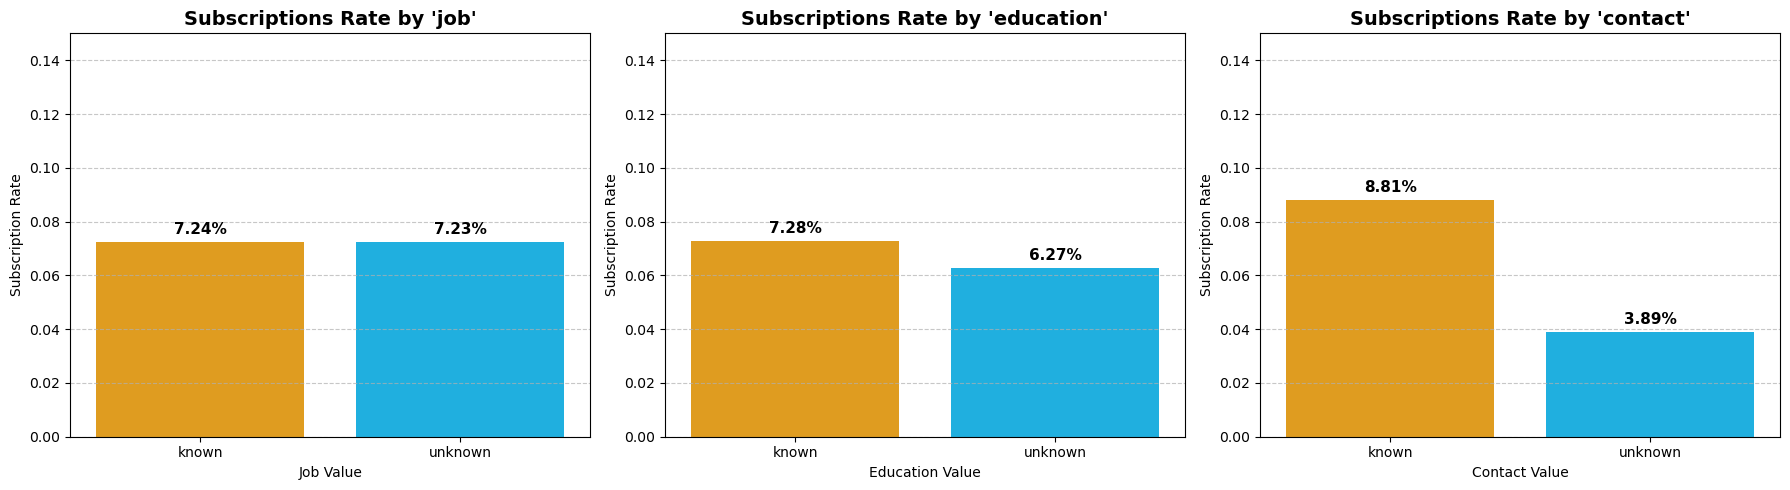

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unknowns(term_deposit):
    unknown_deposit = term_deposit.copy()
    # Convert target to binary
    unknown_deposit["y"] = unknown_deposit["y"].map({"yes": 1, "no": 0})

    # features that contain unknown values
    unknown_features = ['job','education','contact']

    # loop creates new binary columns that indicate whether each row in a feature has unknown value
    """
    - Creates a new binary column for each feature (e.g., job_unknown)
    - True : if the row has value `unknown`
    - False : otherwise
    This allows comparsion between "known" vs "unknown" groups.
    """
    for feature in unknown_features:
        unknown_deposit[f"{feature}_unknown"] = unknown_deposit[feature] == 'unknown'

    # Create a 1x3 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    # Plot success rates (proportion of y=1) for 'unknown' vs 'known' in each feature
    for i, feature in enumerate(unknown_features):
        col = f"{feature}_unknown"
        # compute the average of y (subscription) for each T/F group
        rate_term_deposit = unknown_deposit.groupby(col)["y"].mean().reset_index()
        # Relabel True and False
        rate_term_deposit[col] = rate_term_deposit[col].map({True: "unknown", False: "known"})

        ax = axes[i]
        ax = sns.barplot(data=rate_term_deposit, x=col, y="y", hue=col, palette=["orange", "deepskyblue"], legend=False, ax=ax)

         # Add percentage labels above bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.003,
                    f'{height * 100:.2f}%', ha="center", fontsize=11, fontweight='bold')
            
        ax.set_title(f"Subscriptions Rate by '{feature}'", fontsize=14, fontweight='bold')
        ax.set_ylabel('Subscription Rate')
        ax.set_xlabel(f'{feature.capitalize()} Value')
        ax.set_ylim(0,0.15)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_unknowns(term_deposit)

The percentage of unknown jobs for the category jobs is 0.6%. The total count of unknowns (235) is relatively small so I will keep these rows. From the subscription rate for known and unknown jobs, we see that people who do not disclose their jobs are slightly less likely to subscribe.  

Those with an unknown education have a lower subscription rate of 6.27% compared to known 7.28%. This significant lower subscription rate implies those with unknown education are less financially engaged or less responsive.  

Unknown contacts make up 32% which is a substantial amount of the contacts feature and would not be viable to be dropped from the dataset. Those with unknown contact means have a subscription rate of 3.89% compared to 8.81% This difference suggests that contact type is a meaningful signal. I will keep unknown as a valid level in one-hot encoding instead of imputing or removing this unknown values from the features.


#### Correlation heat map:  

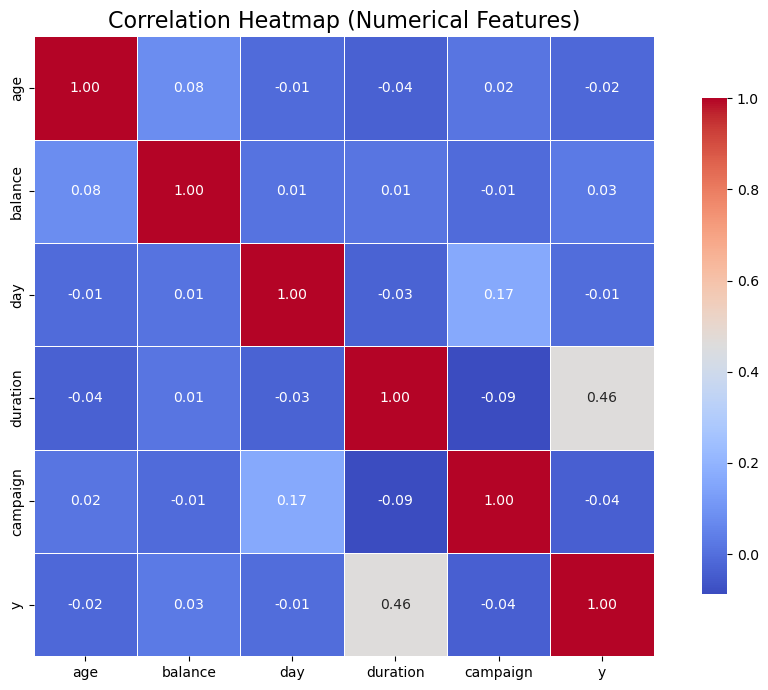

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# heatmap ofr 
def heatmap(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_deposit['y'] = correlation_deposit['y'].map({'yes':1, 'no':0})
    correlation_matrix = correlation_deposit.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10,7))

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
        )
    # Set Title
    ax.set_title("Correlation Heatmap (Numerical Features)", fontsize=16)
    # Adjust layout to prevent clipping
    fig.tight_layout()
    # Show plot
    plt.show()
heatmap(term_deposit)

There is notable correlation between duration and target variable. Very little correlations between each othe features, implies they are independent. No major colinearity among the freatures. 

#### Feature Distributions Numerical
The following plots display the skewness value, histogram shape and Q-Q plot shape for each of the numerical features in the dataset. Q-Q plots, histograms, and skewness values are used to understand the shape and symmetry of the feature distributions in order to decide how I would preprocess features before modeling. The histogram plots will show the distribution of values for the numerical features to give a visual overview of how a feature is spread across its range. The skewness value measures the asymmetry of a distribution. A normal distribution has a skewness ~ 0, a positive skew (right-skewed) visually has a long tail on the right (high values), and a negative skew (left-skewed) visually has a long tail on the left (low values). Quantile-Quantile (QQ) plots were utilized as a graphical tool to compare the distribution of the feature dataset against the normal distribution. Ideally the points should fall roughly on a straight line for the data to approximately be normally distributed. Some models (Logistic Regression, SVM and KNN) assume features are normally distributed and strong skewness or outliers can break these model’s performance.   

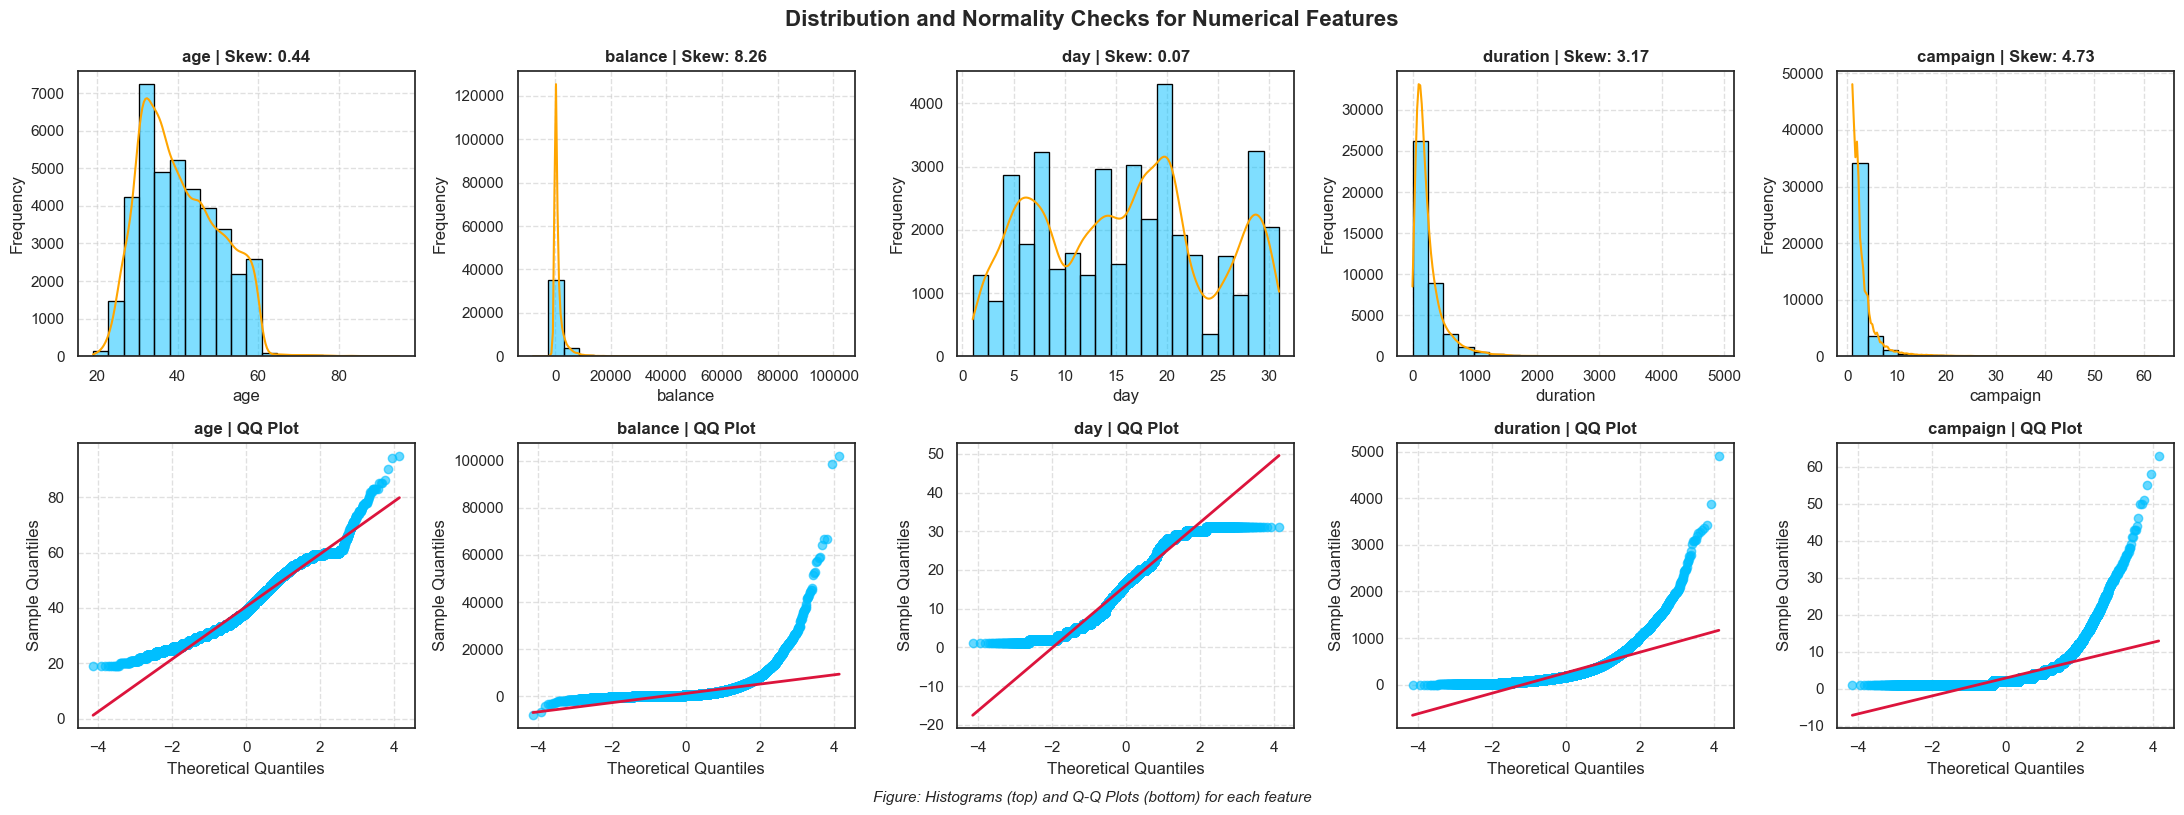

In [7]:
import scipy.stats as stats

# Updated function with bright blue QQ scatterpoints and custom KDE line
def check_skewness_and_qqplots(term_deposit, numerical_cols):
    sns.set_theme(style="white")
    fig, axes = plt.subplots(2,5, figsize=(22,8))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        skew_val = term_deposit[col].skew()

        # Histogram with KDE and custom colors
        sns.histplot(term_deposit[col], bins=20, kde=True, ax=axes[i],
                     color='deepskyblue', edgecolor='black', stat='count')

        # Modify KDE line color manually if present
        if axes[i].lines:
            axes[i].lines[0].set_color('orange')  # change KDE line color

        axes[i].set_title(f'{col} | Skew: {skew_val:.2f}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True, linestyle='--', alpha=0.6)

        # QQ Plot with bright blue scatterpoints and crimson line
        (osm, osr), (slope, intercept, r) = stats.probplot(term_deposit[col], dist="norm")

        axes[i+5].scatter(osm, osr, color='deepskyblue', alpha=0.6)
        axes[i+5].plot(osm, slope * osm + intercept, color='crimson', linewidth=2)
        axes[i+5].set_title(f'{col} | QQ Plot', fontsize=12, fontweight='bold')
        axes[i+5].set_xlabel("Theoretical Quantiles")
        axes[i+5].set_ylabel("Sample Quantiles")
        axes[i+5].grid(True, linestyle='--', alpha=0.6)

    # Adjust layout
    fig.suptitle("Distribution and Normality Checks for Numerical Features", fontsize=16, fontweight='bold')
    #fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.text(0.5, -0.01, 'Figure: Histograms (top) and Q-Q Plots (bottom) for each feature', 
             ha='center', fontsize=11, style='italic')
    plt.tight_layout()
    plt.show()

# Run the customized function
check_skewness_and_qqplots(term_deposit, numerical_cols)

The following can be gleaned for each numerical feature from the prior plots:  

* **age**:  The age variable histogram shows a small tail to the right with a mild slightly positive (right-skewed) value. Age’s QQ plot has the deviated points curving upward confirming the data is right-skewed. Most customers are in their 30s or middle aged with a tail to older years. Interpretation leads to this variable being almost normal with no transformations needed.  

* **balance**: Feature *balance*’s skewness value is very high (~8.9) and its histogram shows a long right tail with many small values and a few large outliers. The feature is strongly right skewed and its QQ plot having heavy S-shaped deviations in upper quantiles. Interpretation of these plots leads to the consideration of using log transformation to reduce skewness before modeling. Most customers have small to moderate balances, but few customers have very large balances pulling the distribution’s tail far to the right.  

* **day**: This variable has little to no skewness. The distribution of the days is fairly uniform across the month, with no strong pattern or bias toward the beginning or end.  

* **duration**: This feature has most of its values concentrated on the left with a sharp right tail. It has a high right-skewed value. From its QQ plot, it has a severe deviation from normality at higher values. Most calls are short but there are a few calls that are very long. Logarithmic transformation will be done on this feature with a cap on long calls to prevent distorting models.  

* **campaign**: Campaign has a high right-sided skewness value where the majority of the clients were contacted a few times and a few outliers were contacted 10+ times. The QQ plot affirms outliers affect the upper quantities. Will cap the long outliers to prevent noise.   


#### Feature Distributions Categorical

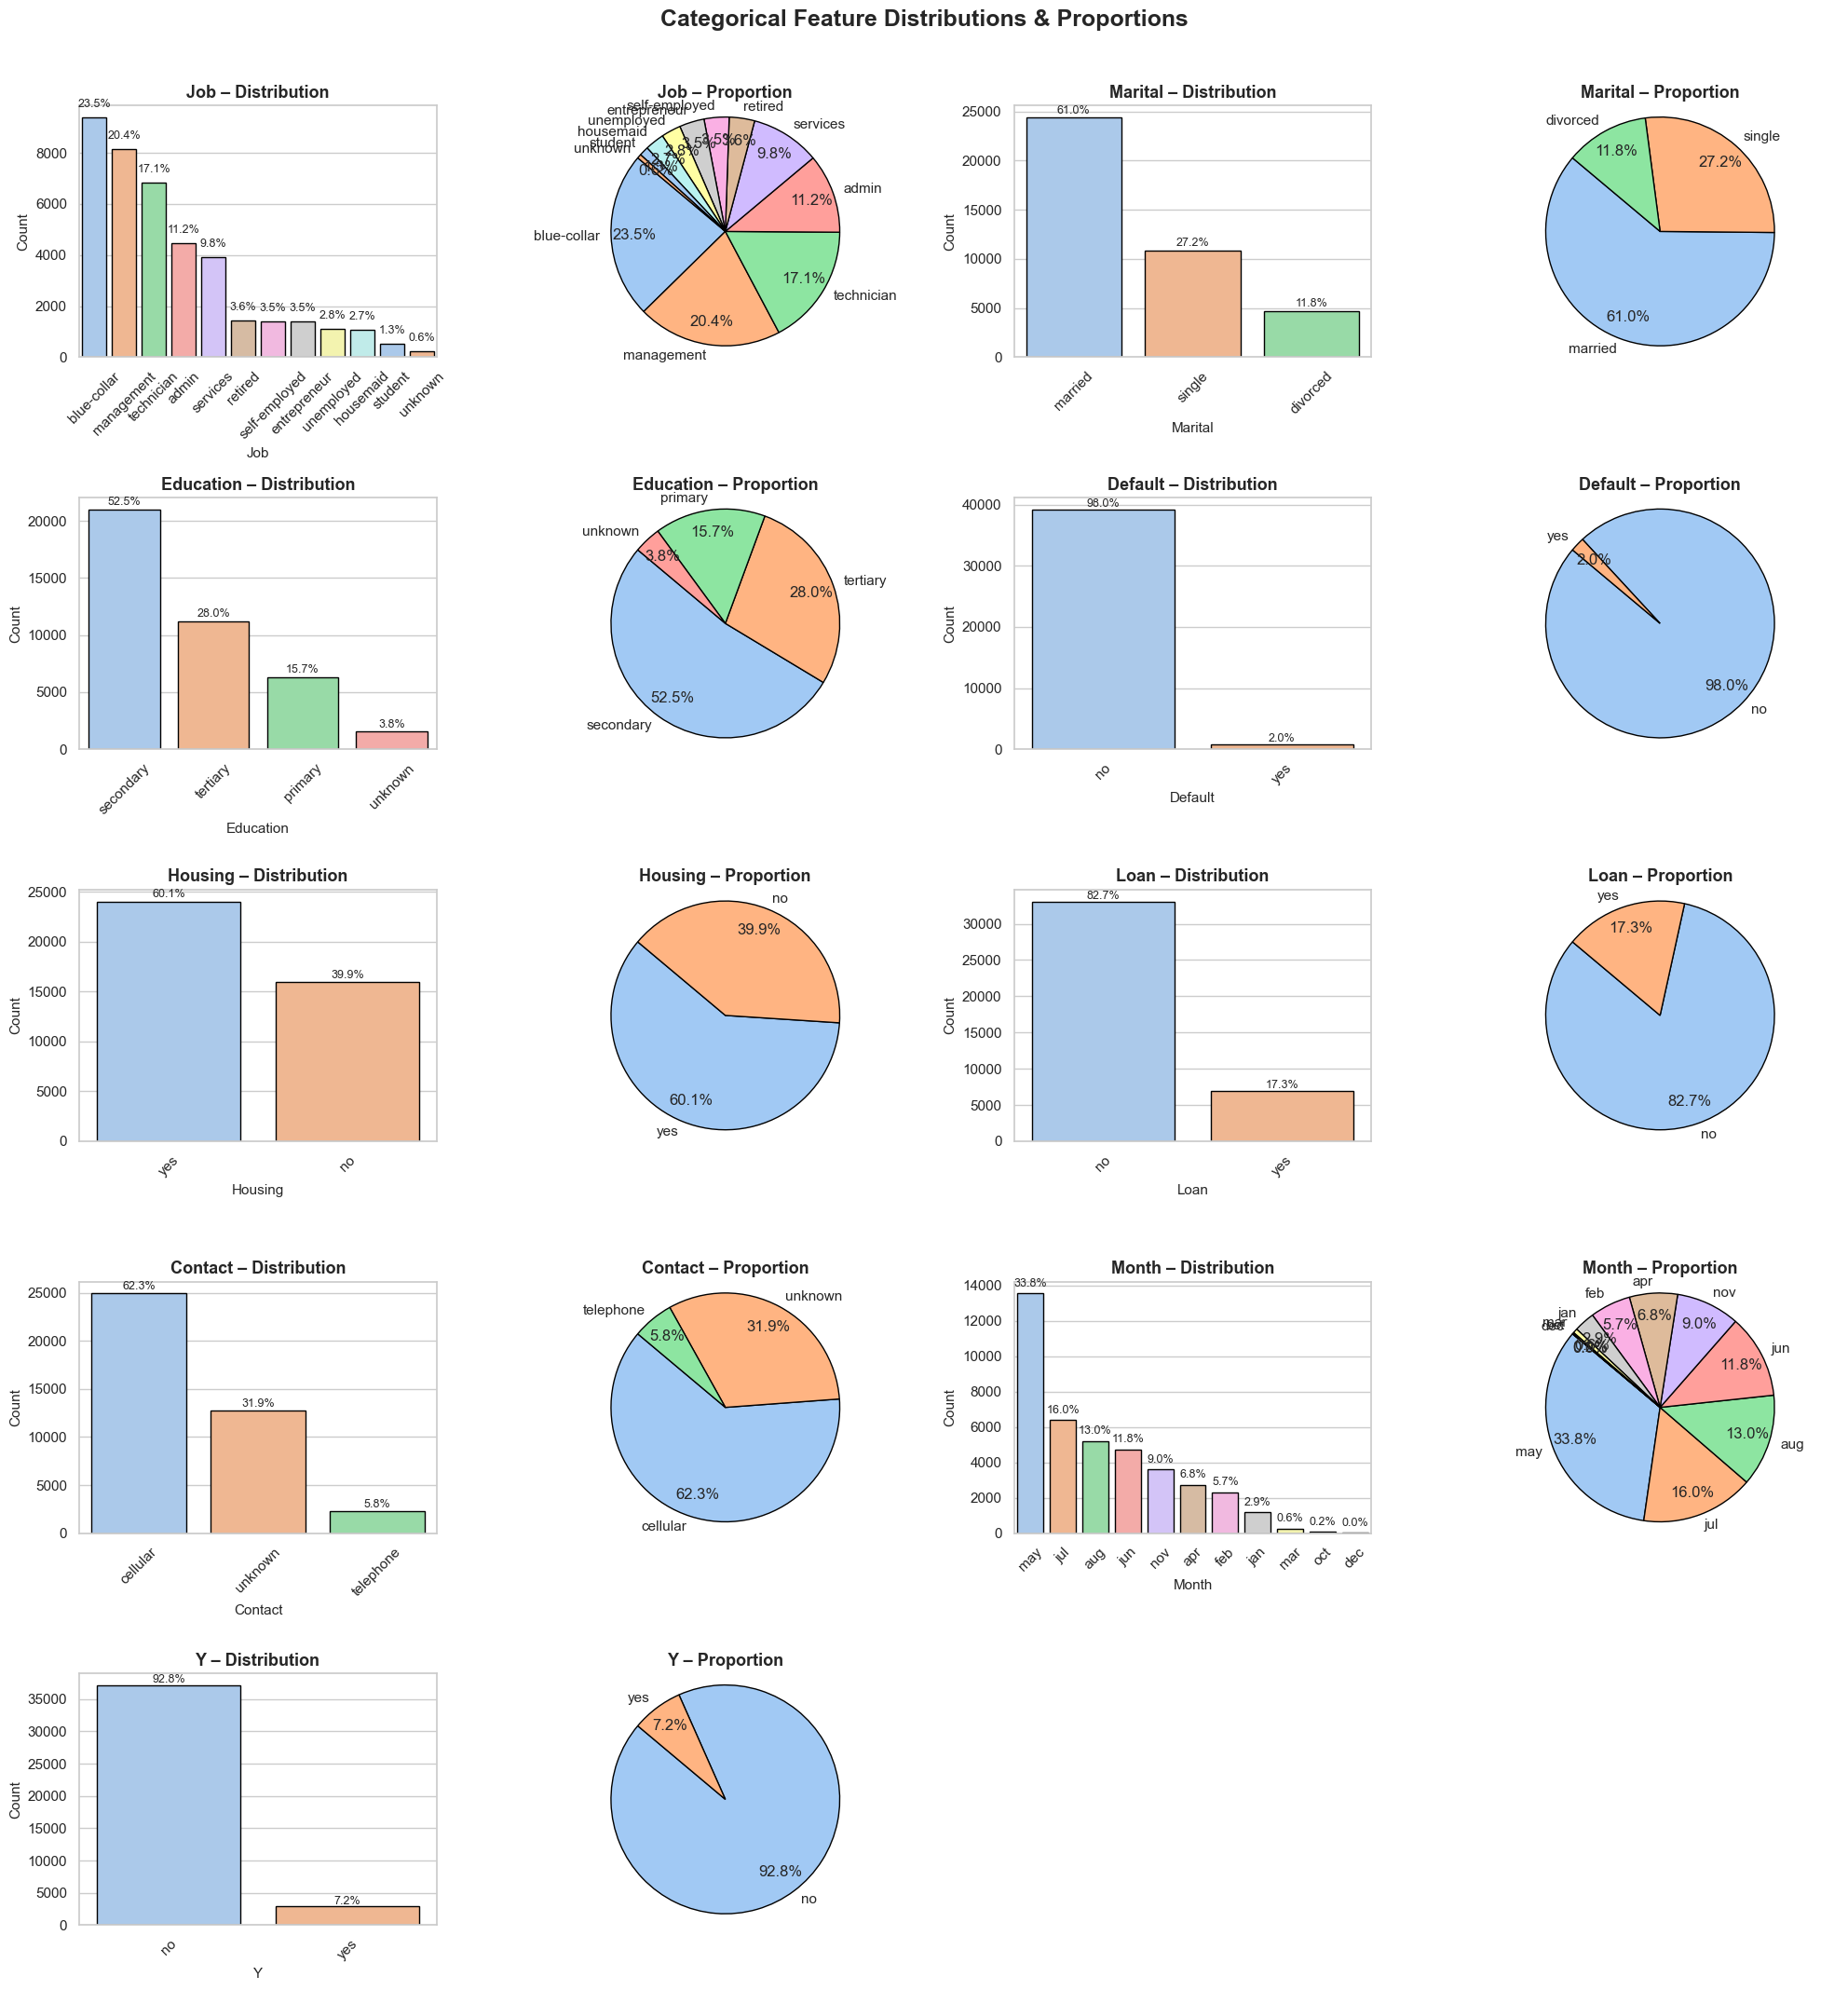

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')


# function to plot bar and pie charts for categorical features in the dataset
def plot_categorical_eda(term_deposit ,categorical_cols):
    """
    Plots bar and pie charts for categorical features in a 5x4 grid layout.
    Parameters:
    term_deposit : 
        The dataset containing categorical features.
    categorical_cols : 
        List of categorical column names to plot 
    """
    color_palette = sns.color_palette('pastel')
    # number of rows in dataset used to compute percentages
    total = len(term_deposit)
    num_features = len(categorical_cols)

    # Set up the 5x4 grid (each feature takes 2 plots: bar and pie)
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 22))
    axes = axes.flatten()

    # Main Plotting Loop
    for i, col in enumerate(categorical_cols):
        # assign bar+pie plots next to each other, 
        bar_ax = axes[2*i]
        pie_ax = axes[2*i+1]

        # Count of each category, preprocessing per column
        value_counts = term_deposit[col].value_counts()
        percentages = (value_counts / total * 100).round(1)

        # Bar Plot Construction
        sns.countplot(
            data=term_deposit,
            x=col,
            order=value_counts.index,
            palette=color_palette,
            ax = bar_ax,
            edgecolor='black'
        )
        # Add percentage labesl above bars
        for j, count in enumerate(value_counts):
            bar_ax.text(j, count + total * 0.01, f'{(count / total * 100):.1f}%', 
                        ha='center', fontsize=9)
        bar_ax.set_title(f'{col.capitalize()} – Distribution', fontsize=13, fontweight='bold')
        bar_ax.set_xlabel(col.capitalize(), fontsize=11)
        bar_ax.set_ylabel("Count", fontsize=11)
        bar_ax.tick_params(axis='x', rotation=45)

        # ---- Pie Chart ----
        pie_ax.pie(
            value_counts,
            labels=value_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.8,
            startangle=140,
            colors=color_palette,
            wedgeprops={'edgecolor': 'black'}
        )
        pie_ax.set_title(f'{col.capitalize()} – Proportion', fontsize=13, fontweight='bold')
        pie_ax.axis('equal')

    # Remove unused axes if any
    for idx in range(2 * num_features, len(axes)):
        fig.delaxes(axes[idx])

    fig.suptitle("Categorical Feature Distributions & Proportions", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.01, 1, 0.97])
    plt.show()
        
plot_categorical_eda(term_deposit, categorical_cols)

        





The following insights can be gleaned from the prior bar and pie charts of the categorical features: 
* **Y**: From the last plot, the distribution of the target variable is heavily imbalanced. Most customers did not subscribe to the term deposit with a subscription rate ~ 7%. Synthetic Minority Over-sampling Technique (SMOTE) will be utilized to handle the imbalance, and the evaluation metric will be adjusted to focus on F1-score instead of accuracy.  

* **Job**: The most common jobs are blue-collar, management, technician, admin and services. Students and retired customers are less frequent but are important as they often show higher subscription rates.

* **Marital**: Most customers are married (*61%*) followed by single and divorced. There is no major imbalance.

* **Education**: Over half of the customer base has a secondary level of education (*52.25%*), followed by tertiary, primary and lastly unknown. 

* **Default**: The vast majority of customers do not have default (96%). This feature is highly imbalanced.
 
* **Housing**: This feature is balanced, with ~60% of the customers having a housing loan. 

* **Loan**: Most customers do not have a personal loan (82.7%). This feature might be useful as having personal loans may impact financial flexibility.

* **Contact**: Majority of contact methods have been via cellular (623%) with unknown following and telephone having a small part. The unknown category is kept as it may indicate poor campaign reach.

* **Month**: From the plots, most calls are made in May, July, August and June. Months like January, March, October and December have very low marketing efforts. Seasonality is important and this feature will be cyclically encoded.


#### Detecting Outliers:  
Interquantile Range (IQR) was used to detect outliers for the numerical features. Many of the numerical features (balance, duration and campaign) are strongly skewed and not normally distributed from the histrogram and QQ plots. IQR focuses on the middle 50% of the data and ignores the extreme values on both ends. This makes it resistant to extreme outliers. 

In [3]:
# Outlier detection using IQR
# identifies and counts the number of outliers in each numerical column of the dataset using the Interquartile Range Method
def detect_outliers_iqr(term_deposit, numerical_cols):
    # compute the 25th and 75th percentile for each numerical column
    Q1 = term_deposit[numerical_cols].quantile(0.25)
    Q3 = term_deposit[numerical_cols].quantile(0.75)
    # calculates the Interquartile range "middle 50%"
    IQR = Q3 - Q1
    # threshold limits of an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # checks for each column which rows fall outside the bounds
    outliers = ((term_deposit[numerical_cols] < lower_bound) | (term_deposit[numerical_cols] > upper_bound)).sum()
    print(outliers[outliers>0])
    

detect_outliers_iqr(term_deposit,numerical_cols)


age           79
balance     4280
duration    3000
campaign    2992
dtype: int64


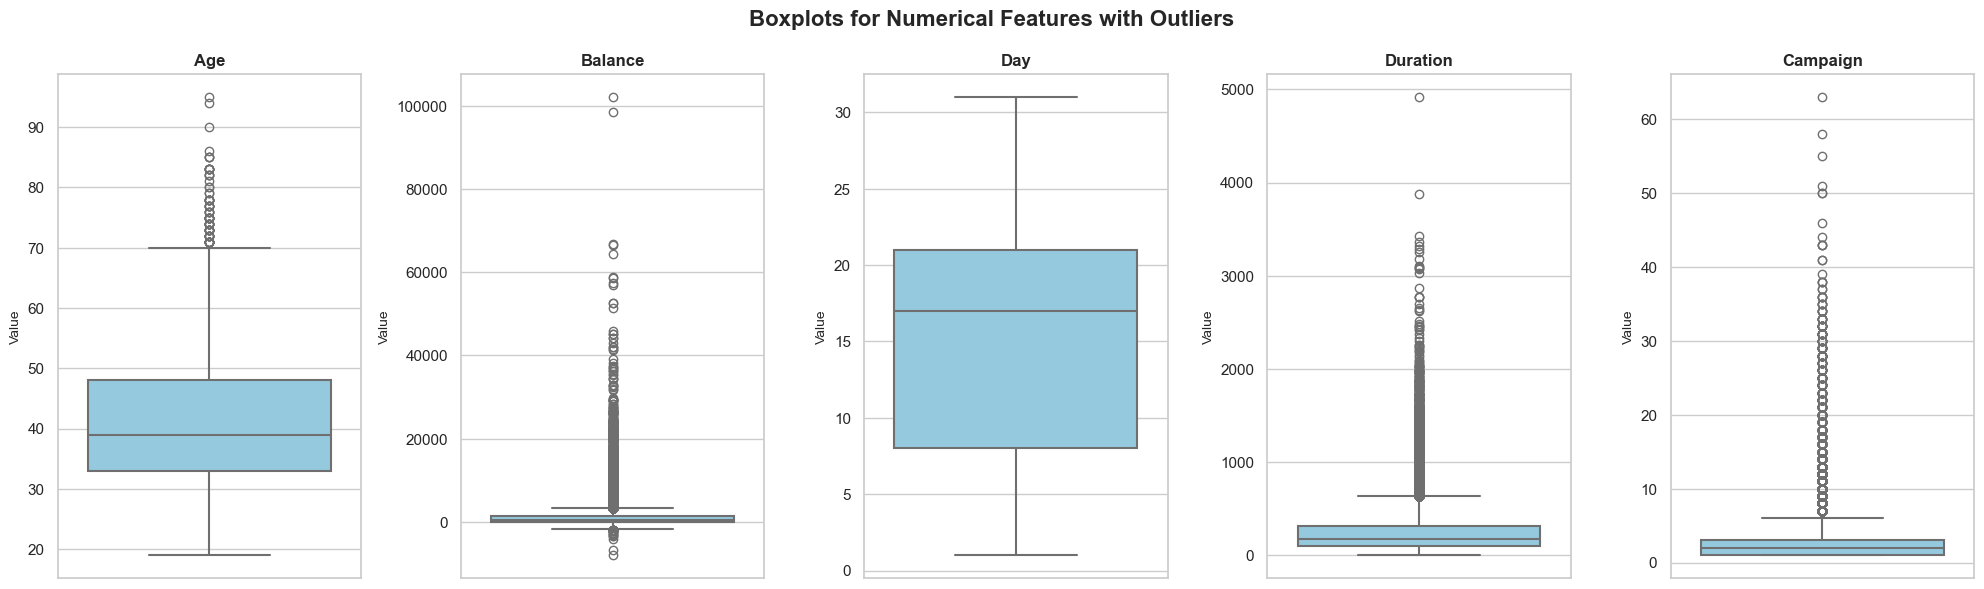

In [ ]:
# boxplot visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_outliers(term_deposit, numerical_cols):
    sns.set_theme(style='whitegrid')
    
    #plt.figure(figsize=(8,4))
    num_features = len(numerical_cols)
    # create subplots, arrange boxplots horizontally (1 row, n columns)
    # each subplot is width 4, height 6, and sharey=False means each plot has it owns y-axis
    fig, axs = plt.subplots(1,num_features, figsize=(4 * num_features, 6), sharey=False)
    for i, num in enumerate(numerical_cols):
        sns.boxplot(y=term_deposit[num], ax=axs[i], color = 'skyblue', linewidth=1.5)
        axs[i].set_title(f"{num.capitalize()}", fontsize=12, fontweight='bold')
        axs[i].set_ylabel('Value', fontsize=10)
    fig.suptitle('Boxplots for Numerical Features with Outliers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

boxplot_outliers(term_deposit, numerical_cols)

#### Overall Insights from numerical features boxplots
* Significant number of outliers in features: Balance, Duration and Campaign. These boxplots confirm from previous findings that these features will need transformation done to them. *Balance* contains negative values (overdrafts) which will be need to be shifted when log transformed as log transforming negative values produce NaN values which will crash machine learning models.
* The outliers in age are natural as there are older customers. Day has no significant outliers. 

### Preprocessing:  
##### One-hot Encoding to handle different data type features (categorical and numerical):  
One-hot encoding is a method to convert categorical features into a numerical format that machine learning models can utlizie. Simply assigning numbers to categories (e.g. job: 'staff' = 2, 'scientist' = 5) can mislead our ML models to think there is an ordinal relationship. The term deposit dataset shown above has 13 features and 40,000 data point of which 9 of the features are categorical. 


In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_term_deposit(term_deposit, numerical_cols, categorical_cols):
    """
    Preprocess the Term Deposit Marketing Dataset based on prior EDA findings:
    Steps:
    - Encode the categorical featues (Label Encode for binary and One-Hot Encode for nominal using sklearn)
    - Log-transform skewed numerical variables
    - Cap extreme campaign values
    - Apply cyclical encoding to month feature
    - Save transformed dataset to a CSV file
    Returns: features X and target Y
    """
    term_deposit = term_deposit.copy()

    # Drop rows with 'unknown' in critical nominal categorical features
    unknown_sensitive_cols = ['job', 'education', 'contact']  # modify based on your domain
    for col in unknown_sensitive_cols:
        if col in term_deposit.columns:
            term_deposit = term_deposit[term_deposit[col].str.lower() != 'unknown']


    categorical_cols = categorical_cols.drop('y', errors='ignore')

    # Target encoding, converting binary target (y) from ('yes', 'no') into (1,0)
    term_deposit['y'] = term_deposit['y'].map({'yes':1, 'no':0})

    # Separate Independent and Target Features
    y = term_deposit['y']
    term_deposit = term_deposit.drop('y', axis=1)   # Remove y to prevent it from being transformed

    # Log Transformation on skewed Numerical Featrues (balance & duration)
    # Balance has negative values, need to shift values to log transform them
    if 'balance' in term_deposit.columns:
        min_balance = term_deposit['balance'].min()
        shift_value = abs(min_balance) + 1 if min_balance <= -1 else 0
        term_deposit['balance'] = np.log1p(term_deposit['balance'] + shift_value)

    # Log transform duration
    if 'duration' in term_deposit.columns:
        term_deposit['duration'] = np.log1p(term_deposit['duration'])
    
    # Cap extreme values for campaign, cap number of times client contacted in campaign at 10
    if 'campaign' in term_deposit.columns:
        term_deposit['campaign'] = np.where(term_deposit['campaign'] > 10, 10, term_deposit['campaign'])

    # Label Encode Binary Categorical Features
    binary_features = ['default', 'housing', 'loan']
    for col in binary_features:
        if col in term_deposit.columns:
            term_deposit[col] = term_deposit[col].map({'yes':1, 'no':0})

    # Cyclical Encoding for 'month' Feature
    if 'month' in term_deposit.columns:
        month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        term_deposit['month_num'] = term_deposit['month'].str.lower().map({m: i+1 for i, m in enumerate(month_order)})
        term_deposit['month_sin'] = np.sin(2 * np.pi * term_deposit['month_num'] / 12)
        term_deposit['month_cos'] = np.cos(2 * np.pi * term_deposit['month_num'] / 12)
        term_deposit.drop(['month', 'month_num'], axis=1, inplace=True)

    # One-Hot Encode Nominal Categorical Features
    # First filter only multi-class nominal features
    nominal_features = [col for col in categorical_cols if col not in binary_features and col != 'month' and term_deposit[col].dtype == 'object']

    # Apply OneHotEncoder onto nominal_features, using sklearn
    encoder = ColumnTransformer(
        transformers=[
            # Drop first category to avoid multicollinearity, returns a dense array and keeps all non-encoded columns
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), nominal_features),
            ('scale', StandardScaler(), numerical_cols)
        ],
        remainder='passthrough'
    )

    # Apply the transformation using the defined pipeline
    transformed_term_deposit = encoder.fit_transform(term_deposit)
    # Get cleaned feature names by manually renaming columns after transformation
    feature_names = encoder.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]
    transformed_term_deposit = pd.DataFrame(transformed_term_deposit, columns=feature_names)

    # Save the processed data
    processed_term = transformed_term_deposit.copy()
    processed_term['y'] = y.values
    output_path = '../data/interim/processed_term_deposit.csv'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    processed_term.to_csv(output_path, index=False)
    
    X = transformed_term_deposit.copy()
    return X, y

X, y = preprocess_term_deposit(term_deposit, numerical_cols, categorical_cols)

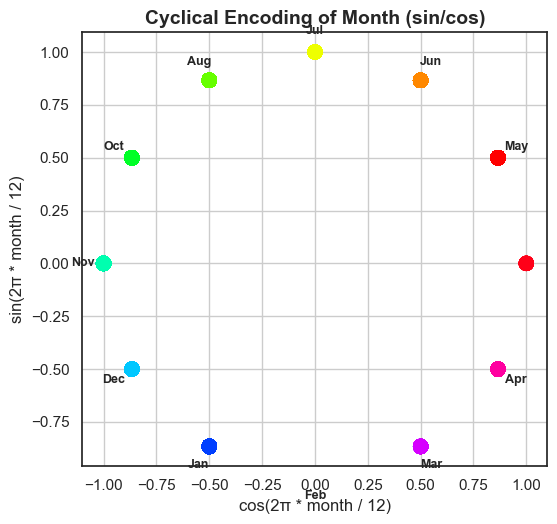

In [15]:
import matplotlib.pyplot as plt

def plot_month_cyclical_encoding(term_deposit):
    # Ensure month has not been dropped yet
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                   'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    term_deposit['month_num'] = term_deposit['month'].str.lower().map({m: i+1 for i, m in enumerate(month_order)})
    term_deposit['month_sin'] = np.sin(2 * np.pi * term_deposit['month_num'] / 12)
    term_deposit['month_cos'] = np.cos(2 * np.pi * term_deposit['month_num'] / 12)

    plt.figure(figsize=(6,6))
    plt.scatter(term_deposit['month_cos'], term_deposit['month_sin'], c=term_deposit['month_num'], cmap='hsv', s=100)
    
    for i, txt in enumerate(term_deposit['month'].unique()):
        angle = 2 * np.pi * (i + 1) / 12
        x = np.cos(angle)
        y = np.sin(angle)
        plt.text(x * 1.1, y * 1.1, txt.capitalize(), ha='center', va='center', fontsize=9, weight='bold')
    
    plt.title('Cyclical Encoding of Month (sin/cos)', fontsize=14, fontweight='bold')
    plt.xlabel('cos(2π * month / 12)')
    plt.ylabel('sin(2π * month / 12)')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

plot_month_cyclical_encoding(term_deposit)

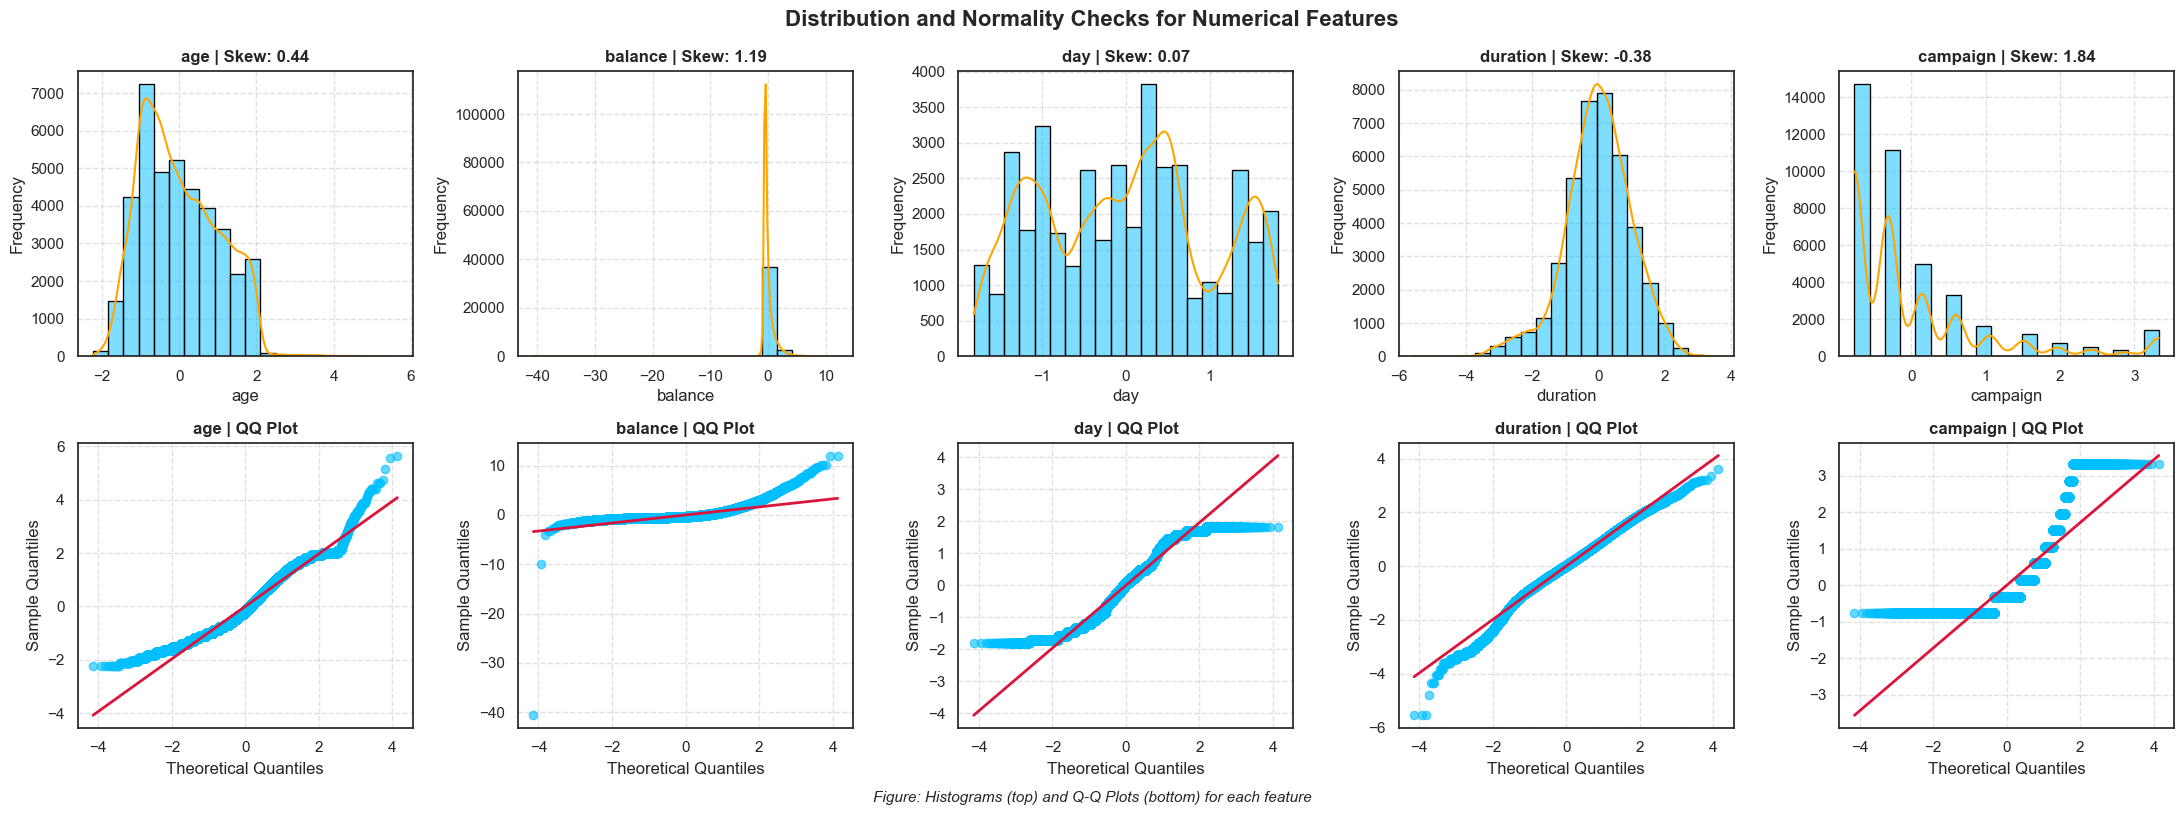

In [13]:
check_skewness_and_qqplots(X, numerical_cols)

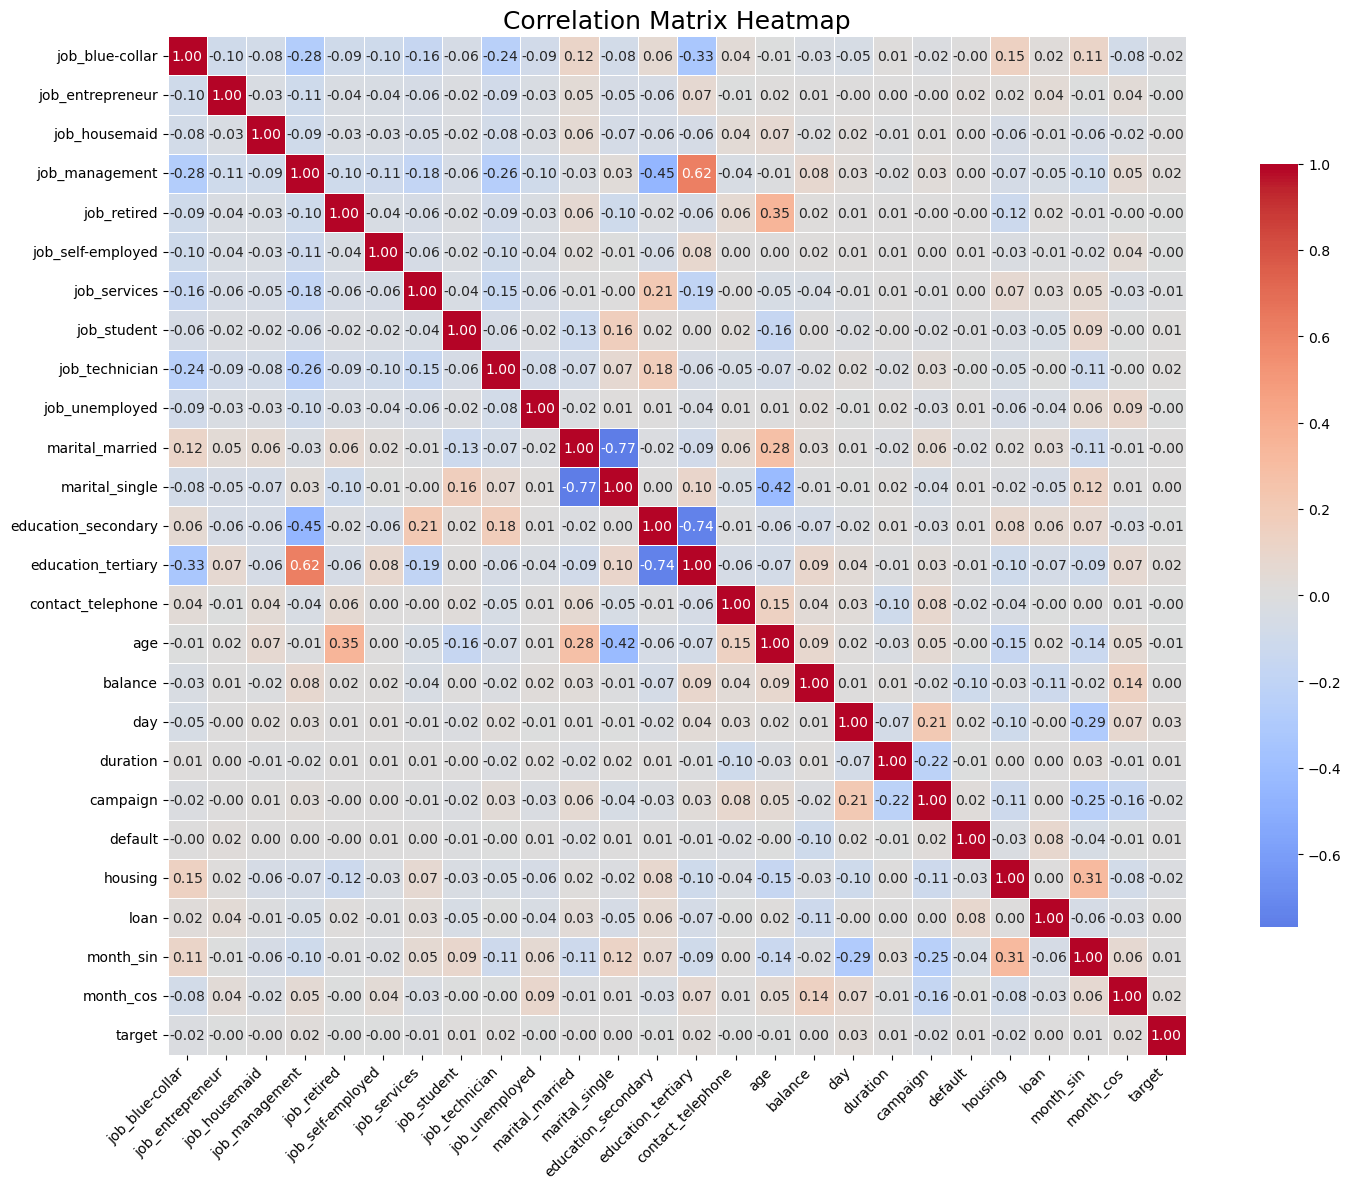

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(X, y_):
    # Combine features and target
    df = X.copy()
    df['target'] = y

    # Compute correlation matrix
    corr = df.corr()

    # Plot heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .75})
    plt.title("Correlation Matrix Heatmap", fontsize=18)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
plot_correlation_heatmap(X, y)

In [6]:
def drop_low_correlation_features(X, y, threshold=0.003):
    """
    Drops features from X_train that have low linear correlation with the target variable.
    
    Parameters:
    - X_train (pd.DataFrame): Feature data
    - y_train (pd.Series): Target variable
    - threshold (float): Minimum absolute correlation value to keep a feature
    
    Returns:
    - X_filtered (pd.DataFrame): X_train with low-correlation features removed
    - dropped_features (list): Names of features that were removed
    """
    # Combine features and target
    df = X.copy()
    df['target'] = y

    # Compute correlation matrix
    corr_matrix = df.corr()
    target_corr = corr_matrix['target'].drop('target')  # drop self-correlation

    # Identify low-correlation features
    low_corr_features = target_corr[(-threshold < target_corr) & (target_corr < threshold)].index.tolist()

    # Drop them from X_train
    X_filtered = X.drop(columns=low_corr_features)

    print(f"Dropped {len(low_corr_features)} features with |correlation| < {threshold}:")
    print(low_corr_features)

    return X_filtered, low_corr_features

X_filtered, low_corr_features = drop_low_correlation_features(X, y)

Dropped 5 features with |correlation| < 0.003:
['job_entrepreneur', 'job_housemaid', 'job_retired', 'job_self-employed', 'marital_married']


### Train/Test Split Transformed Dataset


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset, X is transformed features, y is target 
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, 
    #X,
    y, 
    test_size=0.20, 
    stratify=y, 
    random_state=42
)


### Feature Selection: Combining Statistical, Model-based, and Wrapper Methods

In any supervised machine learning task, selecting the most relevant features is essential for building performant and interpretable models. In this project, we employed a multi-pronged feature selection strategy encompassing filter, embedded, and wrapper methods to robustly identify the features most predictive of customer subscription to a term deposit.

1. Mutual Information (Filter Method)
Mutual Information measures the amount of information one variable provides about another. Unlike linear methods, it can detect non-linear dependencies between features and the target.

We used mutual_info_classif from scikit-learn, which estimates the mutual information between each feature and the binary target (yes or no subscription), helping us prioritize variables that share the most information with the outcome — even in complex, non-linear ways.

2. ANOVA F-Test (Filter Method)
The Analysis of Variance (ANOVA) F-test evaluates the degree to which the means of different groups (in this case, subscribers vs. non-subscribers) vary across feature values. It assumes a linear relationship between each feature and the target and is ideal for selecting features when using linear classifiers.

We used SelectKBest with f_classif, which ranks features based on their F-scores — a statistical measure of between-group vs. within-group variability.

3. L1-Regularized Logistic Regression (Embedded Method)
L1 regularization (also known as Lasso) not only penalizes large weights but also drives less informative feature coefficients to zero — effectively eliminating them. This is an embedded method, meaning the feature selection is part of the model training itself.

By fitting a logistic regression with an L1 penalty, we captured a sparse linear model, identifying which features most strongly contribute to the model’s predictive power.

4. Random Forest Feature Importance (Embedded Method)
Random Forests are ensembles of decision trees that naturally produce feature importances based on Gini impurity reduction — essentially quantifying how much each feature decreases node uncertainty when splitting.

This method is particularly effective in handling non-linearities and interactions between features, making it ideal in real-world datasets like ours with both numerical and categorical data.

5. XGBoost Feature Importance (Embedded Method)
XGBoost is a gradient-boosted tree algorithm that builds an ensemble of trees in a sequential fashion. Like Random Forests, it offers a native importance metric, but is often more aggressive in pruning irrelevant features and handling class imbalance.

We used its gain-based importance scores to identify features that contribute the most to reducing the model's prediction error.

6. Recursive Feature Elimination (Wrapper Method)
Unlike the above methods that evaluate features individually, Recursive Feature Elimination (RFE) considers the interactions between features by training a model iteratively and pruning the least important feature at each step.

We used RFE with Logistic Regression to perform backward elimination, selecting the best-performing subset of features through repeated model training and scoring.

Why Use Multiple Methods?
Each method captures a different notion of "importance":

Filter methods rank features independently of any model.

Embedded methods perform selection during model training.

Wrapper methods optimize feature subsets based on model performance.

By combining these, we gained a well-rounded understanding of which features truly drive customer decision-making.





In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from xgboost import XGBClassifier

def feature_selection(X_train, y_train):
    feature_names = X_train.columns     # extract feature names
    results = pd.DataFrame(index=feature_names)     # initialize empty Dataframe with feature names as index to store scores for each selection method

    # Filter methods, rely on statisitcal characteristics of the data, independent of any model
    # Compute Mutual Information between features and target
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
    results['Mutual_Info'] = pd.Series(mi_scores, index=feature_names)

    # Compute ANOVA F-test scores, selects features using univariate linear regression F-stats
    #  Evaluate if group means for the feature differ significiantly between target classes
    f_test = SelectKBest(score_func=f_classif, k='all')
    f_test.fit(X_train, y_train)
    results['ANOVA_F_test'] = pd.Series(f_test.scores_, index = feature_names)
    #---------------------------------------------------------------------------------------------------------------------

    # Wrapper Method, evaluate feature subset based on model performance
    # Recursive Feature Elimination 
    recursive_feature_elimination = RFE(estimator=LogisticRegression(solver='liblinear', random_state=42), n_features_to_select=20)
    recursive_feature_elimination.fit(X_train, y_train)
    results['RFE_selected'] = recursive_feature_elimination.support_.astype(int)
    #---------------------------------------------------------------------------------------------------------------------

    # Embedded Method
    # L1 Regularization (Lasso), train data on Logistic Regression with L1 regularization
    # storing absolute value of each coef as the importance score
    lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
    lasso.fit(X_train, y_train)
    results['Lasso_coef'] = pd.Series(np.abs(lasso.coef_).flatten(), index=feature_names)

    # Random Forest Feature Importance
    random_forest = RandomForestClassifier(n_estimators=100,random_state=42)
    # Train random forest and store Gini-based importance scores, reflecting how useful each feature was across trees
    random_forest.fit(X_train, y_train)
    results['RF_importance'] = pd.Series(random_forest.feature_importances_, index=feature_names)

    # XGBoost Feature Importance
    # Initialize XGBoost classifier, train on dataset and extract feature importance scores
    xg_Boost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xg_Boost.fit(X_train, y_train)
    results['XGB_importance'] = pd.Series(xg_Boost.feature_importances_, index=feature_names)

    # Rank each column (higher = more important)
    for col in results.columns:
        if col != 'RFE_selected':
            results[f'{col}_rank'] = results[col].rank(ascending=False)

    return results.sort_values('Mutual_Info', ascending=False)



feature_selection_results = feature_selection(X_train, y_train)

c:\Users\aduro\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


LogisticRegression - Features: 1, f1: 0.2910
LogisticRegression - Features: 2, f1: 0.2959
LogisticRegression - Features: 3, f1: 0.3024
LogisticRegression - Features: 4, f1: 0.3077
LogisticRegression - Features: 5, f1: 0.3083
LogisticRegression - Features: 6, f1: 0.3032
LogisticRegression - Features: 7, f1: 0.3107
LogisticRegression - Features: 8, f1: 0.3092
LogisticRegression - Features: 9, f1: 0.3257
LogisticRegression - Features: 10, f1: 0.3277
LogisticRegression - Features: 11, f1: 0.3280
LogisticRegression - Features: 12, f1: 0.3333
LogisticRegression - Features: 13, f1: 0.3335
LogisticRegression - Features: 14, f1: 0.3332
LogisticRegression - Features: 15, f1: 0.3320
LogisticRegression - Features: 16, f1: 0.3330
LogisticRegression - Features: 17, f1: 0.3336
LogisticRegression - Features: 18, f1: 0.3331
LogisticRegression - Features: 19, f1: 0.3358
LogisticRegression - Features: 20, f1: 0.3358
XGBoost - Features: 1, f1: 0.3745
XGBoost - Features: 2, f1: 0.4316
XGBoost - Features: 3

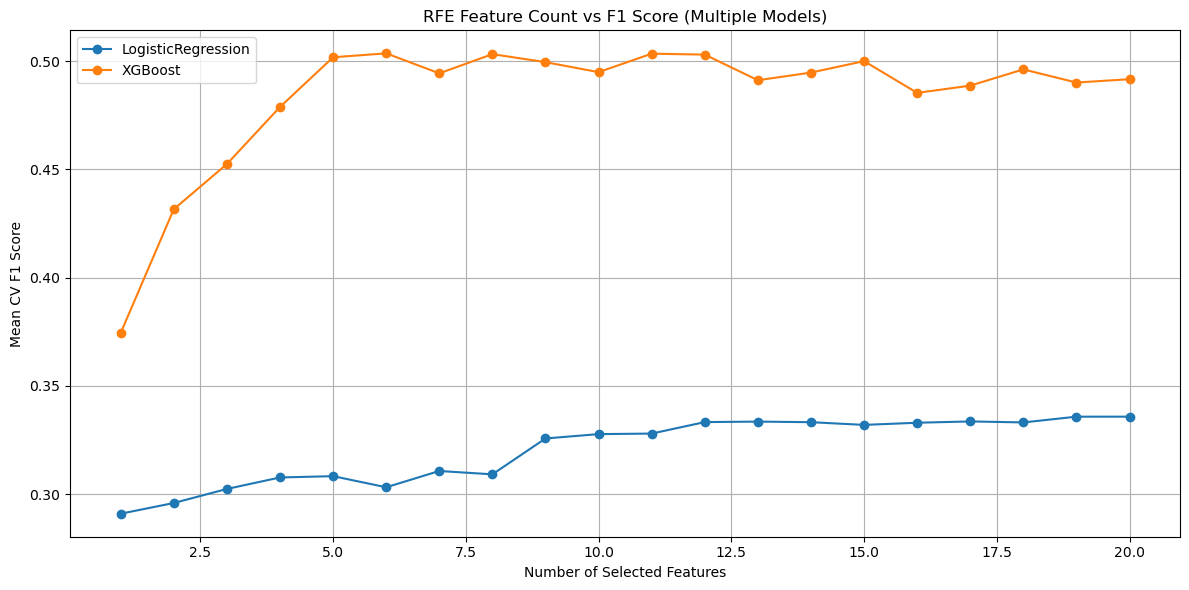

In [169]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_rfe_feature_counts(X_train, y_train, estimators=None, max_features=None, step=1, cv=5, scoring='f1'):
    """
    Evaluates model performance using RFE across different numbers of features for multiple estimators.

    Parameters:
    - X_train: DataFrame of training features
    - y_train: Series of training labels
    - estimators: dictionary of estimators to test (default: LogisticRegression, RandomForest, XGBClassifier)
    - max_features: maximum number of features to test (default: all)
    - step: step size for number of features
    - cv: number of cross-validation folds
    - scoring: scoring metric (default: 'f1')

    Returns:
    - DataFrame summarizing scores for each estimator and feature count
    """
    if estimators is None:
        estimators = {
            'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
            #'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
        }

    if max_features is None:
        max_features = X_train.shape[1]

    feature_range = list(range(step, max_features + 1, step))
    results = []

    for name, estimator in estimators.items():
        scores = []
        for n_features in feature_range:
            rfe = RFE(estimator=estimator, n_features_to_select=n_features)
            X_rfe = rfe.fit_transform(X_train, y_train)
            score = cross_val_score(estimator, X_rfe, y_train, cv=cv, scoring=scoring).mean()
            scores.append(score)
            print(f"{name} - Features: {n_features}, {scoring}: {score:.4f}")
        results.append(pd.DataFrame({
            'n_features': feature_range,
            f'{scoring}_score': scores,
            'model': name
        }))

    result_df = pd.concat(results, ignore_index=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    for name in estimators:
        model_df = result_df[result_df['model'] == name]
        plt.plot(model_df['n_features'], model_df[f'{scoring}_score'], marker='o', label=name)

    plt.title(f'RFE Feature Count vs {scoring.upper()} Score (Multiple Models)')
    plt.xlabel('Number of Selected Features')
    plt.ylabel(f'Mean CV {scoring.upper()} Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


evaluate_rfe_feature_counts(X_train, y_train)


RandomForest - Features: 2, f1: 0.3240
RandomForest - Features: 4, f1: 0.3672
RandomForest - Features: 6, f1: 0.4116
RandomForest - Features: 8, f1: 0.4187
RandomForest - Features: 10, f1: 0.4128
RandomForest - Features: 12, f1: 0.4206
RandomForest - Features: 14, f1: 0.4237
RandomForest - Features: 16, f1: 0.4404
RandomForest - Features: 18, f1: 0.4271
RandomForest - Features: 20, f1: 0.4168


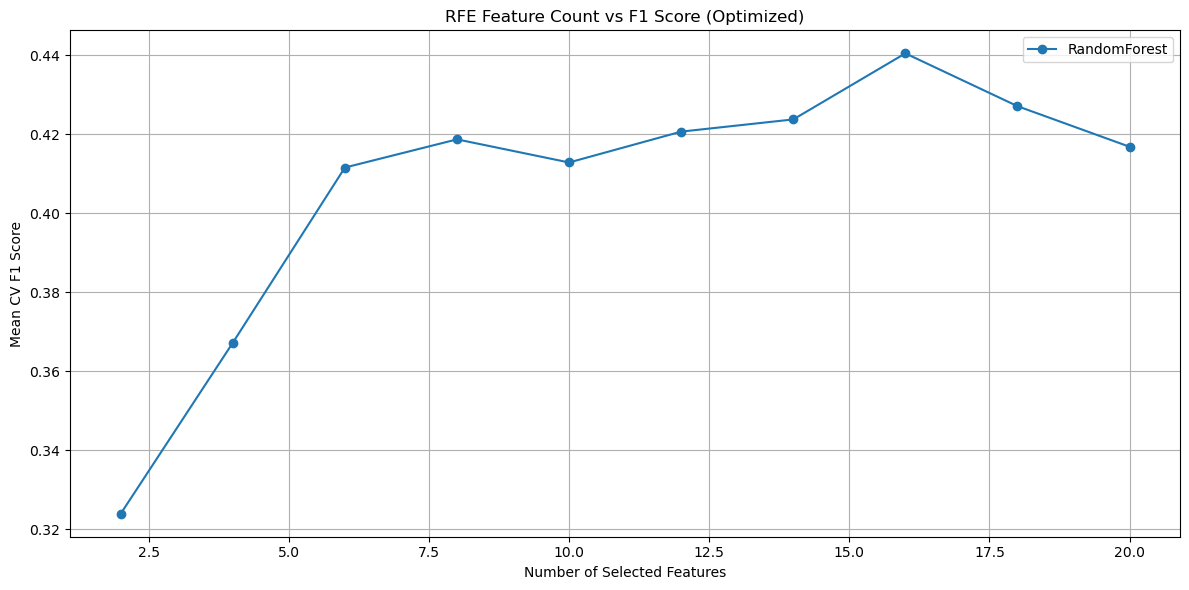

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_rfe_feature_counts_optimized(X_train, y_train, estimators=None, max_features=20, step=2, cv=5, scoring='f1'):
    """
    Optimized version: Evaluates model performance using RFE across different numbers of features.

    Improvements:
    - Parallel cross-validation (n_jobs=-1)
    - Reduced estimators or features
    - Increased step size
    - Limited max_features to reduce iterations
    """
    if estimators is None:
        estimators = {
            # Use only one model at a time for better performance
            # 'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            # 'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
        }

    total_features = X_train.shape[1]
    max_features = min(max_features, total_features)
    feature_range = list(range(step, max_features + 1, step))
    results = []

    for name, estimator in estimators.items():
        scores = []
        for n_features in feature_range:
            rfe = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
            X_rfe = rfe.fit_transform(X_train, y_train)
            score = cross_val_score(estimator, X_rfe, y_train, cv=cv, scoring=scoring, n_jobs=-1).mean()
            scores.append(score)
            print(f"{name} - Features: {n_features}, {scoring}: {score:.4f}")
        results.append(pd.DataFrame({
            'n_features': feature_range,
            f'{scoring}_score': scores,
            'model': name
        }))

    result_df = pd.concat(results, ignore_index=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    for name in estimators:
        model_df = result_df[result_df['model'] == name]
        plt.plot(model_df['n_features'], model_df[f'{scoring}_score'], marker='o', label=name)

    plt.title(f'RFE Feature Count vs {scoring.upper()} Score (Optimized)')
    plt.xlabel('Number of Selected Features')
    plt.ylabel(f'Mean CV {scoring.upper()} Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
evaluate_rfe_feature_counts_optimized(X_train, y_train)


In [ ]:
feature_selection_results.style \
    .set_caption("Feature Selection Summary") \
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold'), ('text-align', 'left')]
        },
        {
            'selector': 'th',
            'props': [('font-size', '11pt'), ('text-align', 'center'), ('font-weight', 'bold')]
        },
        {
            'selector': 'td',
            'props': [('font-size', '10pt'), ('text-align', 'center')]
        }
    ]) \
    .format({col: "{:.6f}" for col in feature_selection_results.columns
             if col not in ["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                            "RF_importance_rank", "XGB_importance_rank"]}) \
    .format({
        col: "{:.0f}" for col in [
            "Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
            "RF_importance_rank", "XGB_importance_rank"
        ]
    }) \
    .background_gradient(
        cmap='Blues_r', axis=0,
        subset=["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                "RF_importance_rank", "XGB_importance_rank"]
    ) \
    .background_gradient(
        cmap='Blues', axis=0,
        subset=[col for col in feature_selection_results.columns
                if col not in ["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                               "RF_importance_rank", "XGB_importance_rank"]]
    )


,Mutual_Info,ANOVA_F_test,RFE_selected,Lasso_coef,RF_importance,XGB_importance,Mutual_Info_rank,ANOVA_F_test_rank,Lasso_coef_rank,RF_importance_rank,XGB_importance_rank
duration,0.082314,3204.157359,1,1.946717,0.378526,0.166714,1,1,1,1,1
month_cos,0.015251,6.457275,1,0.378631,0.039791,0.063566,2,13,7,7,4
month_sin,0.014113,276.051243,1,0.917664,0.056955,0.151162,3,2,2,5,2
day,0.005651,9.180202,1,0.091331,0.107946,0.053132,4,12,13,4,6
balance,0.005501,52.720753,1,0.151611,0.125360,0.027404,5,5,12,2,18
age,0.004228,4.947460,1,0.064009,0.109929,0.028793,6,17,15,3,16
education_tertiary,0.003810,38.167746,1,0.323217,0.011977,0.030107,7,9,9,13,14
education_secondary,0.003588,10.833759,1,0.056291,0.013785,0.023127,8,11,16,10,20
housing,0.002436,52.234414,1,0.883483,0.018658,0.089041,9,6,3,8,3
job_blue-collar,0.001910,21.841328,1,0.383492,0.010826,0.031698,10,10,6,15,11


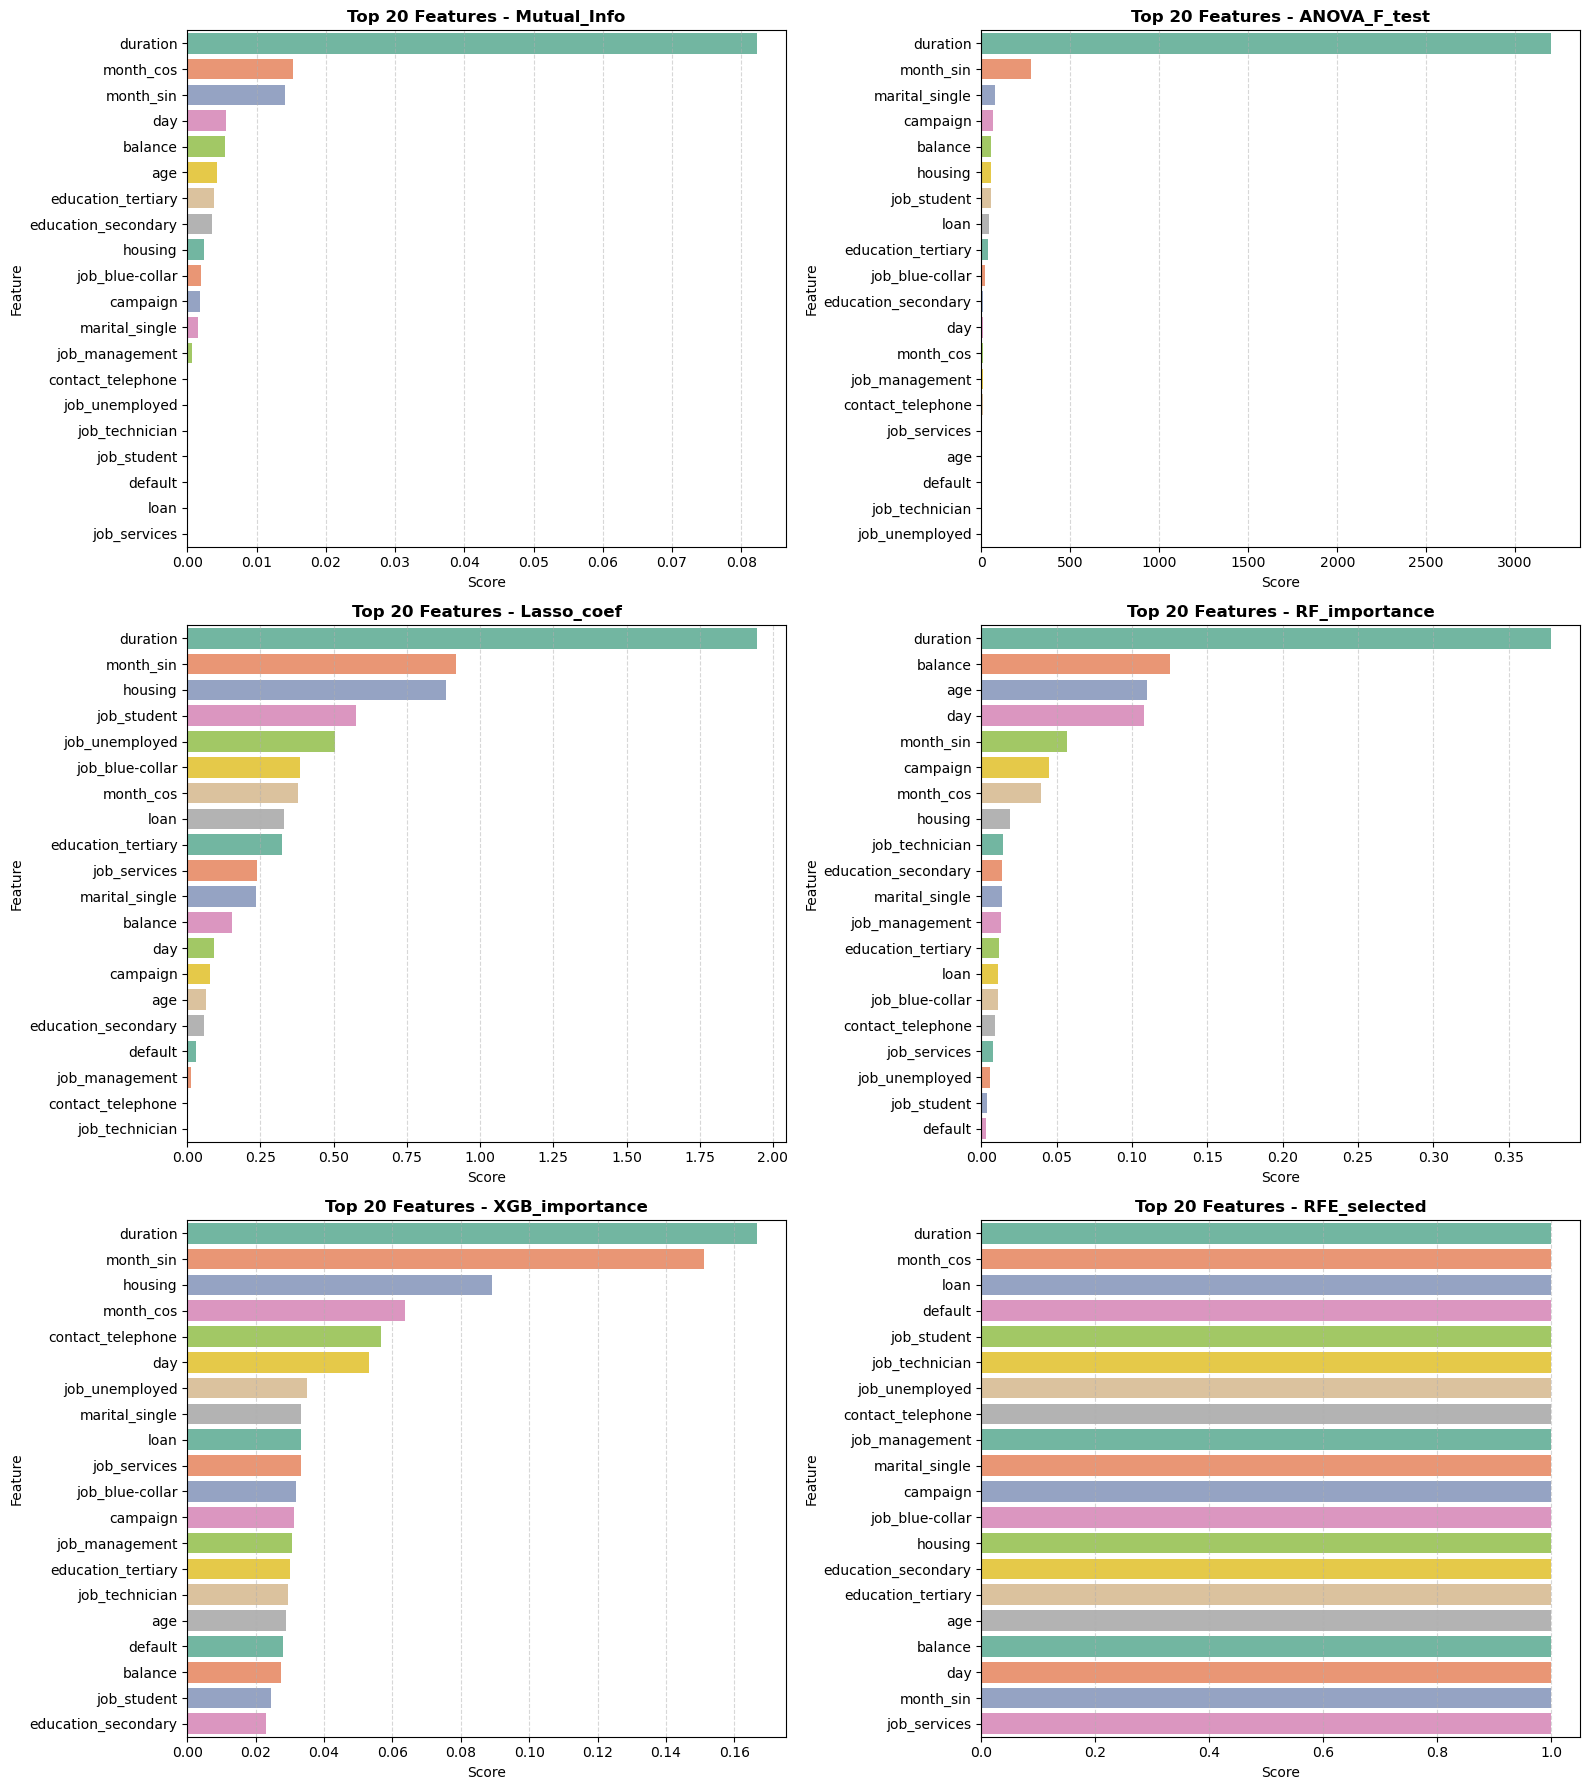

In [170]:
def plot_top_features(results, top_k=20):
    """Plot top_k features from each selection method."""
    importance_cols = ['Mutual_Info', 'ANOVA_F_test', 'Lasso_coef', 'RF_importance', 'XGB_importance', 'RFE_selected']
    melted = results[importance_cols].reset_index().melt(id_vars='index', var_name='Method', value_name='Score')
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    axs = axs.flatten()

    for i, method in enumerate(importance_cols):
        subset = melted[melted['Method'] == method].nlargest(top_k, 'Score')
        sns.barplot(data=subset, y='index', x='Score', ax=axs[i], hue='index', palette='Set2', legend=False)
        axs[i].set_title(f"Top {top_k} Features - {method}", fontsize=12, fontweight='bold')
        axs[i].set_xlabel("Score")
        axs[i].set_ylabel("Feature")
        axs[i].grid(axis='x', linestyle='--', alpha=0.5)

    # Hide unused subplot if any
    if len(importance_cols) < len(axs):
        for j in range(len(importance_cols), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

plot_top_features(feature_selection_results, top_k=20)

### Top Insights from the Feature Importance Plots

From the figures above, we can draw clear insights about month_sin and month_cos which represent cyclical encoding of the month feature. From the feature selection plots, it is clear that both month_sin and month_cos consistently appear in the top 10 features across all selection methods. Strong evidence that month-based seasonality plays an important role in whether customers subscribe. 

1. Consistency Across Methods
  * duration, contact_unknown, month_sin, month_cos and housing consistently appear among the top 5-10 features across Mutual Info, ANOVA, Lasso, Random Forest, XGBoost and Recursive Feature Elimination methods. This consistency across filter, wrapper and embedded methods suggests that the prior features are robust predictors in determing subscritpion rates and should be prioritized. 
  
2. XGBoost Specific Importance
* As I will be using XG Boost as one of the main ML models to predict if the customer will subscribe for a term deposit.
* duration has the highest contribution (~0.16 importance score). Other highly influential features are: contact_unknown, month_sin, month_cos, housing, job_student, contact_telephone, and day. 

3. Cyclical Encoding of month
Both month_sin and month_cos rank highly across XGBoost, Mutual Info, and ANOVA F-test.

This supports your decision to replace one-hot month encoding with cyclical encoding — it captures seasonality effectively and boosts model interpretability/performance.

4. Feature Redundancy and Efficiency
Features like job_housemaid, default, and education_unknown rank very low or appear inconsistently. Consider excluding them unless RFE or domain knowledge suggests otherwise.

RFE_selected shows a dense set of useful features, but some (e.g., job_unknown, job_entrepreneur) appear lower in XGBoost and others — indicating they may not generalize well across models.

📌 Recommendation for XGBoost Modeling
Based on the plots, a strong starting feature set would include:

text
Copy
Edit
duration, contact_unknown, month_sin, month_cos, housing,
job_student, contact_telephone, marital_married, balance, loan
These features:

Are ranked highly in the XGBoost plot

Are supported by at least 3–4 other selection methods

Include temporal, behavioral, and financial predictors

You can then test performance with this compact subset, and compare it to the RFE-selected set or the full top-20 feature set from XGBoost.



### 🔍 Detailed Insights from Feature Selection Plots (28 Features)

The six plots provided illustrate the top 20 features identified by various feature selection techniques: Mutual Information, ANOVA F-test, Lasso Coefficients, Random Forest Importance, XGBoost Importance, and RFE (Recursive Feature Elimination). Together, they offer a comprehensive view of which features contribute most to predicting term deposit subscriptions.

---

#### 📊 1. Mutual Information

* **Key Features**: `duration`, `contact_unknown`, `month_sin`, `month_cos`, `housing`
* **Insight**: Captures non-linear relationships between individual features and the target.
* **Conclusion**: Time-related and communication method features are highly informative. `duration` dominates, and `month_sin/cos` encoding is validated.

---

#### 📊 2. ANOVA F-test

* **Key Features**: `duration`, `contact_unknown`, `month_sin`, `marital_married`, `marital_single`
* **Insight**: Measures linear separability of features.
* **Conclusion**: `duration` has overwhelmingly high linear discriminative power. Marital status and communication type also show linear significance.

---

#### 📊 3. Lasso Coefficients

* **Key Features**: `duration`, `contact_unknown`, `month_sin`, `job_unemployed`, `job_housemaid`
* **Insight**: Sparse linear model that shrinks coefficients of less useful features to zero.
* **Conclusion**: Selects a small, strong subset. `duration` again leads, followed by employment and contact-related features. Encourages parsimonious models.

---

#### 📊 4. Random Forest Importance

* **Key Features**: `duration`, `balance`, `day`, `age`, `month_sin`, `campaign`, `housing`
* **Insight**: Captures feature utility via reduction in Gini impurity across tree splits.
* **Conclusion**: `duration`, `balance`, and temporal features are dominant. Suggests that financial and date-related info is vital for tree-based models.

---

#### 📊 5. XGBoost Importance

* **Key Features**: `duration`, `contact_unknown`, `month_sin`, `housing`, `month_cos`, `job_student`
* **Insight**: Boosted tree-based model capturing interactions and nonlinearities.
* **Conclusion**: Agrees with Random Forest and Mutual Info. Validates cyclical encoding (`month_sin/cos`), and highlights `job_student` as a key demographic.

---

#### 📊 6. Recursive Feature Elimination (RFE)

* **Selected Set**: `duration`, `contact_unknown`, `month_sin`, `month_cos`, `housing`, `marital_married`, `job_blue-collar`, `job_services`, `loan`, `education_tertiary`, and others.
* **Insight**: Wrapper method that recursively removes features and trains models to retain the best-performing subset.
* **Conclusion**: Offers a stable subset for models like Logistic Regression. Many selected features overlap with XGBoost and RF, reinforcing their relevance.

---

### ✅ Additional Insights from RFE Performance Plots:

The RFE performance plots provide empirical validation of how feature count affects model performance.

* **XGBoost Plateau**: The F1-score for XGBoost improves steadily with feature count and begins to plateau around **10–12 features**, indicating a saturation point in performance gains.
* **Logistic Regression Stability**: Shows marginal improvement with feature count and flattens early, reinforcing its dependence on a small, well-selected feature set.
* **Random Forest Optimal Point**: Peaks around **16 features**, then performance declines, showing Random Forest may be more sensitive to irrelevant/noisy features than boosting.

These patterns emphasize the importance of model-specific feature optimization:

* **XGBoost** benefits from interaction-rich, slightly larger subsets (\~10–12).
* **Logistic Regression** prefers compact, linearly separable sets (\~8–10).
* **Random Forest** needs careful balancing to avoid overfitting or noise influence (\~14–16 optimal).

---

### ✅ Overall Feature Selection Insights:

* **High Consensus Features** (appear in most methods):

  * `duration`
  * `month_sin`, `month_cos`
  * `contact_unknown`
  * `housing`
  * `job_student`

* **Moderately Important Features** (appear in 2–3 methods):

  * `balance`, `loan`, `campaign`, `education_tertiary`, `age`, `job_blue-collar`, `job_services`, `day`

* **Low-Priority Features**:

  * `default`, `job_housemaid`, `job_unknown` — weak across most selectors; candidates for removal.

---

### 🧠 Feature Selection Strategy for Modeling:

* **Start with a compact set** of \~10–15 features that score highly across XGBoost, Mutual Info, and RFE.
* **Retain cyclical `month` features** (sin/cos), not dummies — they clearly contribute.
* **Include `duration`, `housing`, and `contact_unknown`** universally identified as predictive.
* **Exclude weak contributors** unless domain knowledge justifies their inclusion.
* **Tailor final feature count** based on model: 10–12 for boosting, 8–10 for logistic regression, 14–16 for random forest.

This multifaceted approach ensures strong generalization and interpretability in subsequent XGBoost modeling.


In [23]:
from sklearn.model_selection import train_test_split

# Split the dataset, X is transformed features, y is target 
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, 
    #X,
    y, 
    test_size=0.15, 
    stratify=y, 
    random_state=42
)


In [11]:
y_train.value_counts()

y
0    19184
1     1852
Name: count, dtype: int64

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import pandas as pd


def resample_training_data(X_train, y_train, random_state=42):
    """
    Applies SMOTE to generate one balanced dataset and RandomUnderSampler to generate another.

    Original class distribution:
    - Class 0: 29683 (92.8%)
    - Class 1: 2317 (7.2%)

    Strategy:
    - SMOTE upsampling to increase minority class to 8000 (~27% of majority class)
    - Undersampling to reduce majority class to 2x the original minority class (4634)

    Parameters:
    - X_train (pd.DataFrame): Training features after feature selection.
    - y_train (pd.Series): Training labels.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X_resampled_smote (pd.DataFrame): SMOTE-resampled training features.
    - y_resampled_smote (pd.Series): SMOTE-resampled training labels.
    - X_resampled_under (pd.DataFrame): Undersampled training features.
    - y_resampled_under (pd.Series): Undersampled training labels.
    """
    # SMOTE resampling
    smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_state)
    #smote = SMOTE(sampling_strategy=0.7, k_neighbors=3, random_state=random_state)
    X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

    # Undersampling
    undersample = TomekLinks(sampling_strategy='auto')
    X_resampled_under, y_resampled_under = undersample.fit_resample(X_train, y_train)

    return X_resampled_smote, y_resampled_smote, X_resampled_under, y_resampled_under

smote_X,smote_Y, under_X, under_Y = resample_training_data(X_train, y_train)

In [13]:
smote_Y.value_counts()

y
1    19184
0    19184
Name: count, dtype: int64

In [14]:
under_Y.value_counts()

y
0    18708
1     1852
Name: count, dtype: int64

In [ ]:
import warnings
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

# Suppress XGBoost and LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)


def cross_validated_model_scores(X, y):
    random_seed = 42
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    cv_results = []

    # Feature subsets for XGBoost and LightGBM
    xgb_features = [
        'duration', 'month_sin', 'month_cos', 'housing', 'contact_telephone',
        'day', 'job_unemployed', 'marital_single', 'loan', 'job_services', 'job_blue-collar', 'campaign', 'job_management', 'education_tertiary', 
        'job_technician'
    ]
    lgbm_features = [
        'duration', 'month_sin', 'month_cos', 'housing', 'contact_telephone',
        'day', 'job_unemployed', 'marital_single', 'loan', 'job_services', 'job_blue-collar', 'campaign', 'job_management'
    ]

    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_seed, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=random_seed),
        'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, verbosity=0, random_state=random_seed),
        'LightGBM': LGBMClassifier(verbosity=-1, random_state=random_seed),
        #'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
        #'Support Vector Machine': SVC(probability=True),
        #'Naive Bayes': GaussianNB(),
        #'K-Nearest Neighbors': KNeighborsClassifier(),
    }

    for name, model in models.items():
        # Select features per model
        if name == 'XGBoost':
            X_use = X[xgb_features]
        elif name == 'LightGBM':
            X_use = X[xgb_features]
        else:
            X_use = X
        #X_use = X

        # Generate cross-validated predictions
        y_cv_pred = cross_val_predict(model, X_use, y, cv=cv, method='predict')
        y_cv_proba = cross_val_predict(model, X_use, y, cv=cv, method='predict_proba')[:, 1]

        # Generate classification report
        report = classification_report(y, y_cv_pred, output_dict=True)
        auc = roc_auc_score(y, y_cv_proba)

        cv_results.append({
            'Model': name,
            'CV F1 (1)': report['1']['f1-score'],
            'CV Precision (1)': report['1']['precision'],
            'CV Recall (1)': report['1']['recall'],
            'CV AUC': auc
        })

    results_df = pd.DataFrame(cv_results).sort_values(by='CV F1 (1)', ascending=False)
    print("Cross-Validated Model Performance")
    display(results_df)
    return results_df

# Example run:
cv_models = cross_validated_model_scores(smote_X, smote_Y)


Cross-Validated Model Performance


,Model,CV F1 (1),CV Precision (1),CV Recall (1),CV AUC
1,Random Forest,0.961264,0.946542,0.976450,0.995258
2,XGBoost,0.958325,0.955428,0.961240,0.993978
3,LightGBM,0.954498,0.945335,0.963841,0.993339
0,Logistic Regression,0.836722,0.814562,0.860122,0.901711


In [37]:
under_sample_initial_models = cross_validated_model_scores(under_X, under_Y)

Cross-Validated Model Performance


,Model,CV F1 (1),CV Precision (1),CV Recall (1),CV AUC
3,LightGBM,0.576480,0.643887,0.521850,0.947549
2,XGBoost,0.566091,0.638978,0.508130,0.944510
1,Random Forest,0.512773,0.662641,0.418191,0.941195
0,Logistic Regression,0.383676,0.611791,0.279472,0.899720
